In [1]:
import numpy as np 

In [80]:
class Dense :
    def __init__ (self,units) : 
        self.units = units 
        self.weight = None 
        self.bias = None 
        self.input_hist = None 
        self.grad_w = None 
        self.grad_b = None 
    
    def __build_weight(self,features) :
        glorot_uniform = np.sqrt(2/(features + self.units))
        self.weight = np.random.uniform(low=-glorot_uniform,high=glorot_uniform,size=(features,self.units))
        self.bias = np.zeros((1,self.units))
    @property
    def get_weight(self) :
        return self.weight,self.bias
    @property
    def get_grad (self) :
        return self.grad_w,self.grad_b
    
    def __call__(self,x) :
        if self.weight is None or self.bias is None :
            self.__build_weight(x.shape[-1])
        self.input_hist = x
        return np.matmul(x,self.weight) + self.bias 
    
    def backward(self,grad) :
        self.grad_w = np.matmul(self.input_hist.swapaxes(-2,-1),grad)
        self.grad_b = np.sum(grad,axis=0,keepdims=True)
        return np.matmul(grad,self.weight.swapaxes(-2,-1))
    
    def update_weight(self,w) :
        self.weight = w 

    def update_bias (self,b) :
        self.bias = b 

In [14]:
class LeakyReLu :
    def __init__ (self,alpha=1e-4) :
        self.alpha = alpha
    
    def __call__(self,x) :
        self.hist = x
        return np.where(x>0,x,self.alpha * x)
    
    def backward(self,grad) :
        self.hist =  np.where(self.hist>0,1,self.alpha)
        grad = self.hist * grad 
        return grad 
    
    @property
    def get_weight(self):
        return None 
    
    @property
    def get_grad (self):
        return None 

class Softmax :
    def __init__(self,epsilon = 1e-6) :
        self.epsilon = epsilon 
    
    def __call__ (self,x) :
        x_max = np.max(x,axis=-1,keepdims=True)
        x_exp = np.exp(x - x_max)
        x_sum = np.sum(x_exp,axis=-1,keepdims=True)
        x_sum[x_sum==0] = self.epsilon
        return x_exp / x_sum
    
    def backward (self,grad) :
        return grad 
    
    @property 
    def get_weight(self) :
        return None 
    
    @property 
    def get_grad (self) :
        return None 

class SparseCategoricallCrossEntropy :
    def __init__(self,epsilon = 1e-6) :
        self.epsilon = epsilon
        self.y_true = None 
        self.y_pred = None 
        self.idx_true = None 
    def __call__ (self,y_true,y_pred) :
        self.y_true = y_true 
        self.y_pred = y_pred 
        y_pred = np.clip(y_pred,self.epsilon,1-self.epsilon)
        self.idx_true = np.arange(len(y_true))
        loss = -np.log(y_pred[self.idx_true,y_true])
        loss = np.mean(loss)
        return loss 
    
    def backward (self) :
        grad = self.y_pred 
        grad[self.idx_true,self.y_true] -=1 
        grad = grad / len(self.y_true)
        return grad 

In [18]:
class Adam :
    def __init__ (self,lr = 1e-3,beta1 = 0.9, beta2 = 0.999,clip_norm = None) :
        self.lr = lr 
        self.beta1 = beta1
        self.beta2 = beta2 
        self.clipnorm = clip_norm
        self.Momentum = None 
        self.Rms = None 
        self.model_weight = None 
        self.grad = None 
        self.iterator = 0
    
    def __build_component (self) :
        self.Momentum = list()
        self.Rms = list() 
        for layers in self.model_weight :
            self.Momentum.append(np.zeros_like(layers))
            self.Rms.append(np.zeros_like(layers))
    
    def apply_weight(self,weight : list) :
        self.model_weight = weight
    
    def apply_grad (self,grad : list) :
        self.grad = grad 

    def __execute (self,weight,grad,M,R) :
        momentum = self.beta1 * M + (1 - self.beta1) * grad 
        rms = self.beta2 * R + (1 - self.beta2) * np.power(grad,2) 
        moment_hat = momentum / (1 - (self.beta1 ** (self.iterator + 1)))
        rms_hat = rms / (1 - (self.beta2 ** (self.iterator + 1)))
        weight-= self.lr / np.sqrt(rms_hat + 1e-6) * moment_hat
        return weight,momentum,rms
    
    def step (self) :
        if self.Momentum is None or self.Rms is None :
            self.__build_component()
        
        for i in range(len(self.model_weight)) :
            if self.clipnorm is not None :
                grad = self.grad[i]
                norm = np.sqrt(np.sum(grad**2))
                scale = self.clipnorm / norm 
                grad *= scale 
            else :
                grad = self.grad[i]
                
            self.model_weight[i],self.Momentum[i],self.Rms[i] = self.__execute(
                weight=self.model_weight[i],grad=grad,
                M = self.Momentum[i],R=self.Rms[i]
            )
        
        self.iterator +=1

        return self.model_weight

In [63]:
class Sequential :
    def __init__ (self,component : list) :
        self.component = component
    
    def get_weight(self) :
        weight = list() 
        for com in self.component :
            wg = com.get_weight
            if wg is not None :
                for w in wg :
                    weight.append(w)
        return weight 
    
    def get_grad(self) :
        grad = list() 
        for com in self.component :
            gl = com.get_grad
            if gl is not None :
                for g in gl :
                    grad.append(g)
        return grad
    
    def backward (self,grad) : 
        for layers in reversed(self.component) :
            grad = layers.backward(grad)
    
    def __call__(self,x) :
        for layers in self.component :
            x = layers(x)
        return x 

    def update (self,weight : list) :
        counter = 0
        for layers in self.component :
            if isinstance(layers,Dense) :
                layers.update_weight = weight[counter]
                layers.update_bias = weight[counter]
            counter +=1 


In [119]:

import matplotlib.pyplot as plt

In [113]:
loss_record = list()
accuracy_record = list()

In [100]:
from sklearn.datasets import make_classification

In [105]:
x_train,y_train = make_classification(n_samples=1000,n_classes=4,n_informative=10)

In [114]:
Model = Sequential([
    Dense(64),
    LeakyReLu(),
    Dense(128),
    LeakyReLu(),
    Dense(32),
    LeakyReLu(),
    Dense(4),
    Softmax(epsilon=1e-7)
])
optim_fn = Adam(lr=1e-3,clip_norm=4.0)
loss_fn = SparseCategoricallCrossEntropy()

In [84]:
Model.get_grad()[0].shape

(4, 64)

In [115]:
for epoch in range(100) : 
    y_pred = Model(x_train.copy())
    loss = loss_fn(y_train,y_pred)
    accuracy = np.mean((np.argmax(y_pred,axis=-1) == y_train).astype(int))
    loss_record.append(loss)
    accuracy_record.append(accuracy)
    print(f"epoch : {epoch + 1} | loss : {loss:.6f} | Accuracy : {accuracy:.6f}")
    grad_loss = loss_fn.backward()
    Model.backward(grad_loss)
    optim_fn.apply_weight(Model.get_weight())
    optim_fn.apply_grad(Model.get_grad())
    new_weight = optim_fn.step()
    Model.update(new_weight)

    

epoch : 1 | loss : 1.384594 | Accuracy : 0.236000
epoch : 2 | loss : 1.368959 | Accuracy : 0.339000
epoch : 3 | loss : 1.354113 | Accuracy : 0.420000
epoch : 4 | loss : 1.339513 | Accuracy : 0.456000
epoch : 5 | loss : 1.324735 | Accuracy : 0.483000
epoch : 6 | loss : 1.309549 | Accuracy : 0.507000
epoch : 7 | loss : 1.293913 | Accuracy : 0.534000
epoch : 8 | loss : 1.277845 | Accuracy : 0.555000
epoch : 9 | loss : 1.261329 | Accuracy : 0.569000
epoch : 10 | loss : 1.244388 | Accuracy : 0.576000
epoch : 11 | loss : 1.227003 | Accuracy : 0.583000
epoch : 12 | loss : 1.209242 | Accuracy : 0.592000
epoch : 13 | loss : 1.191015 | Accuracy : 0.597000
epoch : 14 | loss : 1.172418 | Accuracy : 0.608000
epoch : 15 | loss : 1.153480 | Accuracy : 0.615000
epoch : 16 | loss : 1.134241 | Accuracy : 0.623000
epoch : 17 | loss : 1.114718 | Accuracy : 0.629000
epoch : 18 | loss : 1.094921 | Accuracy : 0.632000
epoch : 19 | loss : 1.074874 | Accuracy : 0.640000
epoch : 20 | loss : 1.054649 | Accuracy 

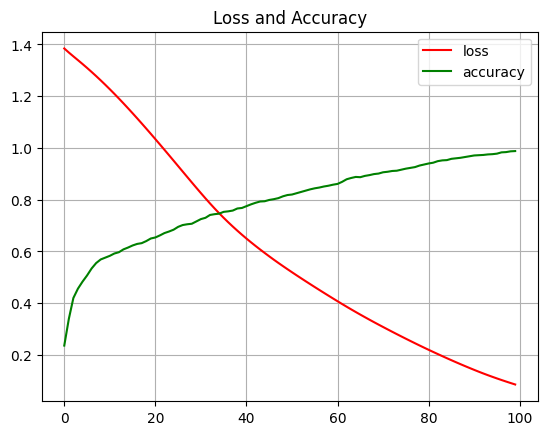

In [118]:
plt.title("Loss and Accuracy")
plt.plot(np.arange(100),np.array(loss_record),label="loss",color="red")
plt.plot(np.arange(100),np.array(accuracy_record),label="accuracy",color="green")
plt.legend()
plt.grid(True)
plt.show()